In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from typing import Dict
from matplotlib import cm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from collections import defaultdict

# Data loading and setup

In [2]:
from load_data import load_data
mibig_metadata, mibig_pfam, mibig_cathdb, funfams, sbp, sbp_all_pfam, bios = load_data()

(851, 20)
(918, 166)
(1519, 17)
(96, 10)
(863, 29)
(1345, 100)


In [3]:
mibig_struct = mibig_metadata[pd.notnull(mibig_metadata.Structure)]
merged_struct = pd.merge(mibig_struct, sbp_all_pfam, on='BGC')

In [10]:
## Class sizes
print(merged_struct.query("LOGP < 0").shape[0])
print(merged_struct.query("LOGP >= 0").shape[0])

220
350


In [11]:
## Setup for learning
mibig_struct['label'] = -1
mibig_struct.loc[mibig_struct.LOGP < 0, 'label'] = 0
mibig_struct.loc[mibig_struct.LOGP >= 0, 'label'] = 1
mibig_struct_ml = mibig_struct[mibig_struct['label'] >= 0][['BGC', 'Gram', 'label']]

mw_data = {}
mw_data['pfam'] = sbp_all_pfam.merge(mibig_struct_ml, on='BGC', how='inner')
mw_data['cath'] = mibig_cathdb.merge(mibig_struct_ml, on='BGC', how='inner')
mw_data['biosynthetic'] = bios.merge(mibig_struct_ml, on='BGC', how='inner')

# Statistical tests

In [52]:
import scipy.stats as stats

cols = mw_data['pfam'].columns.drop(["BGC", "Gram", "label"])[mw_data['pfam'][mw_data['pfam'].columns.drop(["BGC", "Gram", "label"])].sum() >= 5]
# cols = list(cols)

mw_plus = mw_data['pfam'].query("label == 1")
mw_minus = mw_data['pfam'].query("label == 0")
## Run z-tests
pvalues1 = []

for pfam in cols:
    compare1 = [mw_plus[pfam].sum(),mw_minus[pfam].sum()]
    compare2 = [mw_plus[cols.drop(pfam)].sum().sum(), mw_minus[cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues1.append(pvalue)
    
## Multiple correction
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')

i = 0
for pfam in cols:
    compare = [mw_plus[pfam].astype(bool).sum(),mw_minus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print(pfam)
        print(str(int(compare[0] / mw_plus.shape[0] * 100)))
        print(str(int(compare[1] / mw_minus.shape[0] * 100)))
        print(t1[1][i])
        
    i += 1

ABC_membrane
13
30
1.1623237819561824e-05
FecCD
1
4
0.0018868673687737858
FtsX
8
4
0.0018868673687737858
MFS_3
2
9
0.006633352160900986
MFS_1
49
40
0.007569510566455587
ABC2_membrane_3
3
0
0.0030731586368109185
MacB_PCD
5
2
0.0077024473831528726
ABC2_membrane_4
0
5
5.698504790690852e-05
MMPL
5
0
0.00011952168429384424


In [39]:
mw_data['pfam'].columns

Index(['BGC', 'ABC_tran', 'BPD_transp_1', 'TonB_dep_Rec', 'ABC_membrane',
       'ACR_tran', 'FecCD', 'ABC2_membrane', 'MatE', 'OEP', 'FtsX', 'MFS_3',
       'MFS_1', 'ABC2_membrane_2', 'ABC2_membrane_3', 'MacB_PCD',
       'ABC2_membrane_4', 'MMPL', 'BPD_transp_2', 'Multi_Drug_Res',
       'PBP_like_2', 'SBP_bac_3', 'Peripla_BP_2', 'SBP_bac_1', 'SBP_bac_11',
       'Peripla_BP_6', 'Peripla_BP_4', 'SBP_bac_5', 'SBP_bac_8', 'Gram',
       'label'],
      dtype='object')

In [49]:
merged_struct.query("LOGP < 0")[merged_struct.query("LOGP < 0").BGC.isin(mw_data['pfam'].query("ABC_membrane > 0")['BGC'])]['LOGP'].mean()

-5.313364696969697

In [50]:
merged_struct.LOGP.mean()

0.3251447017543858

# Machine learning

In [71]:
def plot_pr_curves(precisions, recalls, names, task, cmap_name="tab20"):
    cm = plt.get_cmap(cmap_name)

    _recalls = recalls
    _precisions = precisions
    cgen = [cm(1. * i/len(_recalls)) for i in range(len(_recalls))]

    plt.figure(figsize=(5, 5))
    for color, precision, recall, key in zip(cgen, _precisions, _recalls, names):
        step_kwargs = ({'step': 'post'}
                      if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, alpha=0.8, color=color, linewidth=5, linestyle='-',
                 where='post', label=key)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
    plt.legend()
    plt.savefig("pr_curve_logp.svg")
    plt.show()

In [63]:
## Classifier
from sklearn.preprocessing import StandardScaler

def fit_classifier(data, clf_type):
    if clf_type == 'lasso':
        clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga', class_weight='balanced', max_iter=1000)
    elif clf_type == 'tree':
        clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)

    X = data[data.columns.drop(['BGC', 'label'])]

    y = data['label']
    
    n_split = 5
    n_repeats = 5
    
    ## metrics
    precisions = []
    recalls = []
    accuracies = []
    auprcs = []
    
    ## cross validation
    coefs = []
    for i in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_split)
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            #save scores
            precisions.append(precision_score(y_test, preds, zero_division=0))
            recalls.append(recall_score(y_test, preds))
            accuracies.append(accuracy_score(y_test, preds))
            auprcs.append(average_precision_score(y_test, preds))
            if clf_type == 'lasso':
                coef = clf.coef_.ravel()
                coefs.append(coef)
    ## calculate medians and range
    cv_precision = np.mean(precisions)
    cv_recall = np.mean(recalls)
    cv_accuracy = np.mean(accuracies)
    cv_aupcr = np.mean(auprcs)

    ## Now run on entire dataset
    scaler = StandardScaler()
    X_orig = X
    X = pd.DataFrame(scaler.fit_transform(X))
    clf.fit(X, y)
    preds = clf.predict_proba(X)
    precisions, recalls, _ = precision_recall_curve(y, preds[:, 1])
    auprc = average_precision_score(y, preds[:, 1])
    variables = []
    dfs = []
    # get features if it's a lasso 
    if clf_type == 'lasso':
        coefs = np.array(coefs)
        results = pd.DataFrame(coefs)
        results = results.rename(columns={i: f for i, f in enumerate(X_orig.columns)})
        results = results.melt(var_name='feature', value_name='vals')
        dfs.append(results)
        dfs = pd.concat(dfs)
        dfs2 = dfs[dfs.vals.abs() >= 0.25]
        dfs = dfs[dfs.feature.isin(dfs2.feature.unique())]
        dfs = dfs.sort_values('vals', ascending=False)
        
    fit = {"precisions": precisions, "recalls": recalls, "features": dfs, "auprc": auprc, "cv_precision": cv_precision, "cv_recall":cv_recall, "cv_accuracy": cv_accuracy, "cv_aupcr": cv_aupcr}
    return fit            

In [64]:
combined = pd.merge(mw_data['pfam'], mw_data['biosynthetic'], on='BGC', how='right')
combined['label'] = combined.label_y
combined['Gram'] = combined.Gram_y
combined['label'] = combined.label_y
del combined['Gram_y']
del combined['Gram_x']
del combined['label_y']
del combined['label_x']
combined = combined.fillna(0)

results = {}
results['pfam_1'] = fit_classifier(mw_data['pfam'], clf_type='tree')
results['cath_1'] = fit_classifier(mw_data['cath'], clf_type='tree')
results['bios_1'] = fit_classifier(mw_data['biosynthetic'], clf_type='tree')
results['combined_1'] = fit_classifier(combined, clf_type='tree')

results['pfam_1_l'] = fit_classifier(mw_data['pfam'], clf_type='lasso')
results['cath_1_l'] = fit_classifier(mw_data['cath'], clf_type='lasso')
results['bios_1_l'] = fit_classifier(mw_data['biosynthetic'], clf_type='lasso')
results['combined_1_l'] = fit_classifier(combined, clf_type='lasso')


In [65]:
results_table = defaultdict(list)
for r in results:
    results_table['Task'].append(r)
    results_table['Precision (Cross Validation)'].append(results[r]['cv_precision'])
    results_table['Recall (Cross Validation)'].append(results[r]['cv_recall'])
    results_table['Accuracy (Cross Validation)'].append(results[r]['cv_accuracy'])
    results_table['AUPRC Total'].append(results[r]['auprc'])
    results_table['AUPRC (Cross Validation)'].append(results[r]['cv_aupcr'])
    
pd.DataFrame(results_table)

,Task,Precision (Cross Validation),Recall (Cross Validation),Accuracy (Cross Validation),AUPRC Total,AUPRC (Cross Validation)
0,pfam_1,0.658522,0.857143,0.636842,0.677718,0.651790
1,cath_1,0.697221,0.868421,0.672000,0.702795,0.686370
2,bios_1,0.803948,0.863810,0.722896,0.862291,0.770205
3,combined_1,0.768198,0.971601,0.768612,0.862291,0.766356
4,pfam_1_l,0.688148,0.724571,0.627719,0.783830,0.668110
5,cath_1_l,0.715386,0.728947,0.643667,0.874007,0.693342
6,bios_1_l,0.869079,0.717579,0.719352,0.957868,0.826202
7,combined_1_l,0.866389,0.762421,0.743465,0.968401,0.827748


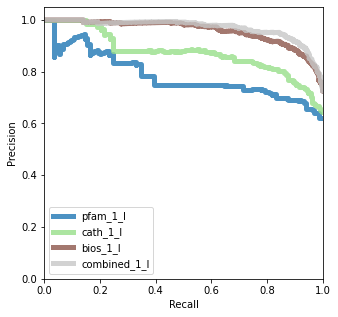

In [66]:
precisions = []
recalls = []
names = []

for r in results:
    if '_l' in r:
        names.append(r)
        precisions.append(results[r]['precisions'])
        recalls.append(results[r]['recalls'])
plot_pr_curves(precisions, recalls, names, "Siderophore")


# Stability analysis

In [67]:
def plot_features(dfs, name, figsize):
    plt.figure(figsize=figsize)
    
    sns.swarmplot(x='vals', y='feature', data=dfs, size=5)
    sns.boxplot(x='vals', y='feature', data=dfs, color='white')

    plt.ylabel('')
    plt.xlabel('Effect Size (LASSO Linear Regression)')
    plt.title(name)
    plt.savefig('logp_' + name + ".svg")
    plt.show()

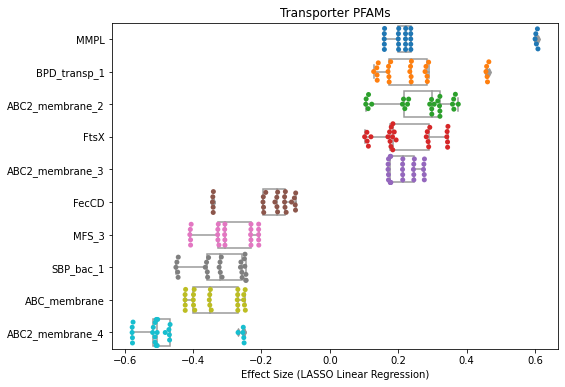

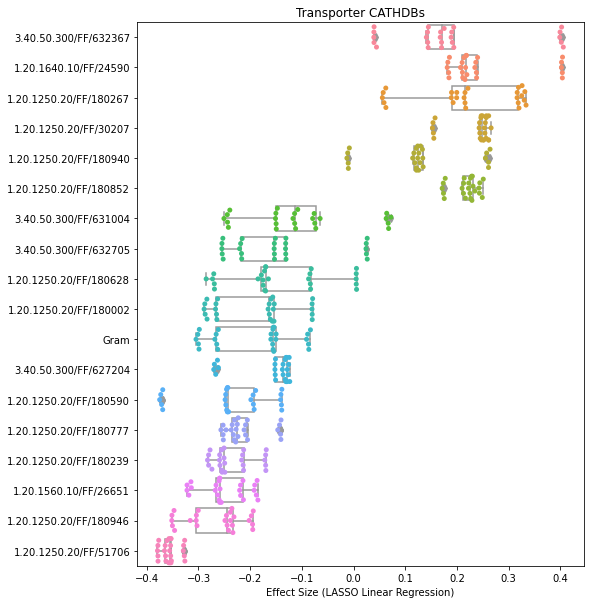

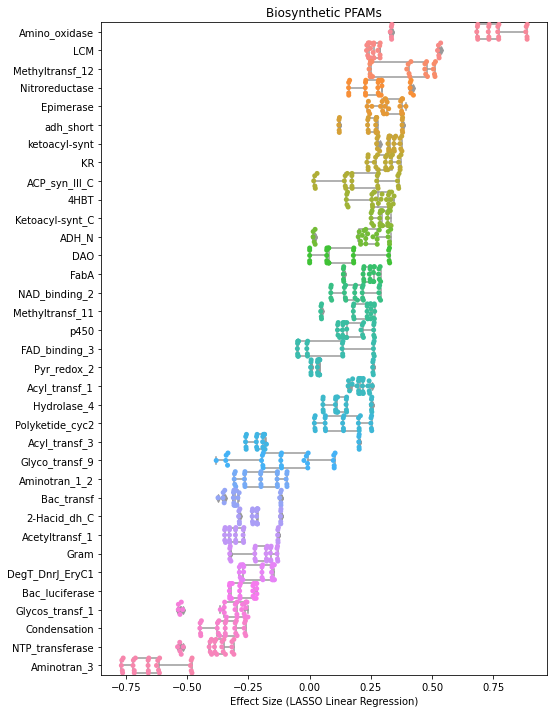

In [70]:
plot_features(results['pfam_1_l']['features'], 'Transporter PFAMs', (8,6))
plot_features(results['cath_1_l']['features'], 'Transporter CATHDBs', (8,10))
plot_features(results['bios_1_l']['features'], 'Biosynthetic PFAMs', (8,12))